# RQ2: Policy domain analysis

This notebook analyses which policy domains dominate in different document types. We compare motioner (bottom-up MP proposals) and propositioner (top-down government bills) across eight policy domains, testing whether government bills focus more on competitiveness and innovation whilst motioner emphasise ethics and social impacts.

## Setup and imports

In [1]:
import re
from pathlib import Path
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

# configure visualisation defaults
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 10
sns.set_palette(['#9b59b6', '#e91e63', '#34495e', '#95a5a6'])

## Data loading

Load all documents from both directories and parse their metadata headers to create a structured dataset.

In [2]:
def parse_document(filepath):
    """extract metadata and content from a parliamentary document file."""
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # split header from content
    parts = content.split('=' * 80)
    if len(parts) < 2:
        return None
    
    header = parts[0]
    doc_content = parts[1].strip()
    
    # extract metadata fields
    metadata = {}
    for line in header.strip().split('\n'):
        if ':' in line:
            key, value = line.split(':', 1)
            metadata[key.strip().lower()] = value.strip()
    
    return {
        'doc_id': metadata.get('document id', ''),
        'title': metadata.get('title', ''),
        'date': metadata.get('date', ''),
        'year': metadata.get('parliamentary year', ''),
        'search_term': metadata.get('search term', ''),
        'content': doc_content,
        'filepath': str(filepath)
    }

In [3]:
# load motioner
mot_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/data/motioner')
mot_files = list(mot_dir.glob('*.txt'))
mot_docs = [parse_document(f) for f in mot_files]
mot_docs = [doc for doc in mot_docs if doc is not None]

for doc in mot_docs:
    doc['doc_type'] = 'mot'

# load propositioner
prop_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/data/propositioner')
prop_files = list(prop_dir.glob('*.txt'))
prop_docs = [parse_document(f) for f in prop_files]
prop_docs = [doc for doc in prop_docs if doc is not None]

for doc in prop_docs:
    doc['doc_type'] = 'prop'

# combine into dataframe
all_docs = mot_docs + prop_docs
df = pd.DataFrame(all_docs)

print(f"loaded {len(mot_docs)} motioner and {len(prop_docs)} propositioner")
print(f"total documents: {len(df)}")
df.head()

loaded 452 motioner and 700 propositioner
total documents: 1152


,doc_id,title,date,year,search_term,content,filepath,doc_type
0,hd023729,Internationellt samarbete i en utmanande tid,2025-10-07,2025/26,artificiell intelligens,<style><!-- \n @page Section1 { size:595.3pt 8...,/Users/simon/Dropbox/wrk/active/research/riksd...,mot
1,hd023645,"Utgiftsområde 9 Hälsovård, sjukvård och social...",2025-10-07,2025/26,AI,<style><!-- \n @page Section1 { size:595.3pt 8...,/Users/simon/Dropbox/wrk/active/research/riksd...,mot
2,hc02351,Pornografi och sexuell exploatering på nätet,2024-09-24,2024/25,AI,<style><!-- \n @page Section1 { size:595.3pt 8...,/Users/simon/Dropbox/wrk/active/research/riksd...,mot
3,ha021483,Användning av moderna tester för prostatacancer,2022-11-22,2022/23,AI,<style><!-- \n @page Section1 { size:595.3pt 8...,/Users/simon/Dropbox/wrk/active/research/riksd...,mot
4,h5022531,Utgiftsområde 24 Näringsliv,2017-10-04,2017/18,artificiell intelligens,<style><!-- \n /******************************...,/Users/simon/Dropbox/wrk/active/research/riksd...,mot


## Text preprocessing

Remove HTML tags and extract clean text for analysis.

In [4]:
def clean_html(html_text):
    """remove html tags and extract plain text."""
    soup = BeautifulSoup(html_text, 'html.parser')
    text = soup.get_text()
    # normalise whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['content'].apply(clean_html)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

print(f"average document length: {df['word_count'].mean():.0f} words")
df.groupby('doc_type')['word_count'].describe()

average document length: 52590 words


,count,mean,std,min,25%,50%,75%,max
doc_type,,,,,,,,
mot,452.0,6490.818584,8784.346010,133.0,777.25,3149.0,8230.75,55438.0
prop,700.0,82357.245714,101851.489997,2855.0,25444.25,53448.5,104145.75,1748186.0


## Policy domain dictionaries

Define Swedish keyword lists for eight policy domains relevant to AI discourse. Keywords capture both direct mentions and related concepts.

In [5]:
# define policy domain dictionaries with swedish keywords
policy_domains = {
    'labour': [
        'arbete', 'arbetslöshet', 'sysselsättning', 'anställning', 'jobb',
        'arbetsmarknad', 'arbetskraft', 'yrke', 'kompetens', 'lön',
        'arbetsgivare', 'arbetstagare', 'fackförbund', 'fack', 'anställd'
    ],
    'education': [
        'utbildning', 'skola', 'universitet', 'högskola', 'lärande',
        'undervisning', 'kunskap', 'forskning', 'student', 'elev',
        'lärare', 'pedagog', 'kurs', 'yrkesutbildning', 'vidareutbildning'
    ],
    'healthcare': [
        'hälsa', 'vård', 'sjukvård', 'omsorg', 'patient', 'medicin',
        'behandling', 'diagnos', 'sjukhus', 'vårdcentral', 'äldreomsorg',
        'hälso', 'medicinsk', 'klinik', 'läkare'
    ],
    'defence': [
        'försvar', 'säkerhet', 'militär', 'cyber', 'hot', 'terrorism',
        'beredskap', 'försvarsmakt', 'säkerhetspolisen', 'must',
        'cybersäkerhet', 'terrorhot', 'krishantering', 'totalförsvar'
    ],
    'innovation': [
        'innovation', 'näringsliv', 'företag', 'startup', 'tillväxt',
        'konkurrens', 'industri', 'digitalisering', 'export', 'investering',
        'konkurrenskraft', 'produktivitet', 'affär', 'marknad', 'ekonomi'
    ],
    'ethics': [
        'etik', 'integritet', 'rättighet', 'demokrati', 'transparens',
        'ansvar', 'diskriminering', 'jämlikhet', 'jämställdhet', 'mänsklig',
        'gdpr', 'personuppgift', 'datasky dd', 'fördom', 'bias'
    ],
    'environment': [
        'miljö', 'klimat', 'hållbar', 'energi', 'utsläpp', 'klimatmål',
        'klimatförändring', 'klimatpåverkan', 'fossilfri', 'förnybar',
        'koldioxid', 'hållbarhet', 'ekologi', 'grön'
    ],
    'public_sector': [
        'myndighet', 'offentlig', 'förvaltning', 'kommun', 'region',
        'stat', 'statlig', 'kommunal', 'digital förvaltning', 'e-förvaltning',
        'service', 'välfärd', 'myndighetsutövning', 'landsting'
    ]
}

# display domain sizes
for domain, keywords in policy_domains.items():
    print(f"{domain}: {len(keywords)} keywords")

labour: 15 keywords
education: 15 keywords
healthcare: 15 keywords
defence: 14 keywords
innovation: 15 keywords
ethics: 15 keywords
environment: 14 keywords
public_sector: 14 keywords


## Domain frequency analysis

Count domain keyword occurrences in each document and normalise by document length to enable fair comparison.

In [6]:
def count_domain_words(text, word_list):
    """count occurrences of domain keywords in text."""
    text_lower = text.lower()
    count = 0
    for word in word_list:
        # word boundary matching with suffix tolerance
        count += len(re.findall(r'\b' + word + r'\w*\b', text_lower))
    return count

# calculate domain frequencies for each document
for domain, keywords in policy_domains.items():
    # raw counts
    df[f'{domain}_count'] = df['clean_text'].apply(lambda x: count_domain_words(x, keywords))
    # normalised per 1000 words
    df[f'{domain}_per_1k'] = (df[f'{domain}_count'] / df['word_count']) * 1000

# display sample
domain_cols = [f'{d}_per_1k' for d in policy_domains.keys()]
df[['doc_id', 'doc_type'] + domain_cols].head()

,doc_id,doc_type,labour_per_1k,education_per_1k,healthcare_per_1k,defence_per_1k,innovation_per_1k,ethics_per_1k,environment_per_1k,public_sector_per_1k
0,hd023729,mot,2.475248,0.977071,0.065138,7.881709,4.103700,13.223033,6.709224,4.624805
1,hd023645,mot,6.881381,2.876643,32.009702,1.381917,3.158667,2.481809,0.169214,14.524226
2,hc02351,mot,0.000000,0.000000,0.000000,0.000000,4.878049,2.439024,0.000000,0.000000
3,ha021483,mot,0.000000,0.000000,24.271845,0.000000,0.000000,0.000000,0.000000,0.000000
4,h5022531,mot,7.029877,4.100762,2.343292,0.000000,48.037493,4.686585,2.343292,14.059754


## Domain profiles by document type

Calculate mean domain frequencies for each document type to identify characteristic patterns.

In [7]:
# aggregate domain frequencies by document type
domain_summary = df.groupby('doc_type')[[f'{d}_per_1k' for d in policy_domains.keys()]].mean()

# rename columns for clarity
domain_summary.columns = list(policy_domains.keys())

# transpose for better readability
domain_summary_t = domain_summary.T
domain_summary_t.columns = ['motioner', 'propositioner']

# calculate difference (mot - prop)
domain_summary_t['difference'] = domain_summary_t['motioner'] - domain_summary_t['propositioner']

# sort by absolute difference
domain_summary_t['abs_diff'] = domain_summary_t['difference'].abs()
domain_summary_t = domain_summary_t.sort_values('abs_diff', ascending=False)

domain_summary_t.round(2)

,motioner,propositioner,difference,abs_diff
innovation,12.01,6.02,5.99,5.99
education,7.71,2.26,5.45,5.45
labour,6.67,2.69,3.98,3.98
healthcare,5.05,1.81,3.24,3.24
environment,5.06,2.96,2.10,2.10
defence,4.55,2.85,1.70,1.70
ethics,4.43,3.07,1.36,1.36
public_sector,10.82,10.01,0.81,0.81


## Visualisations

Create comparative visualisations showing domain profiles and their distribution across document types.

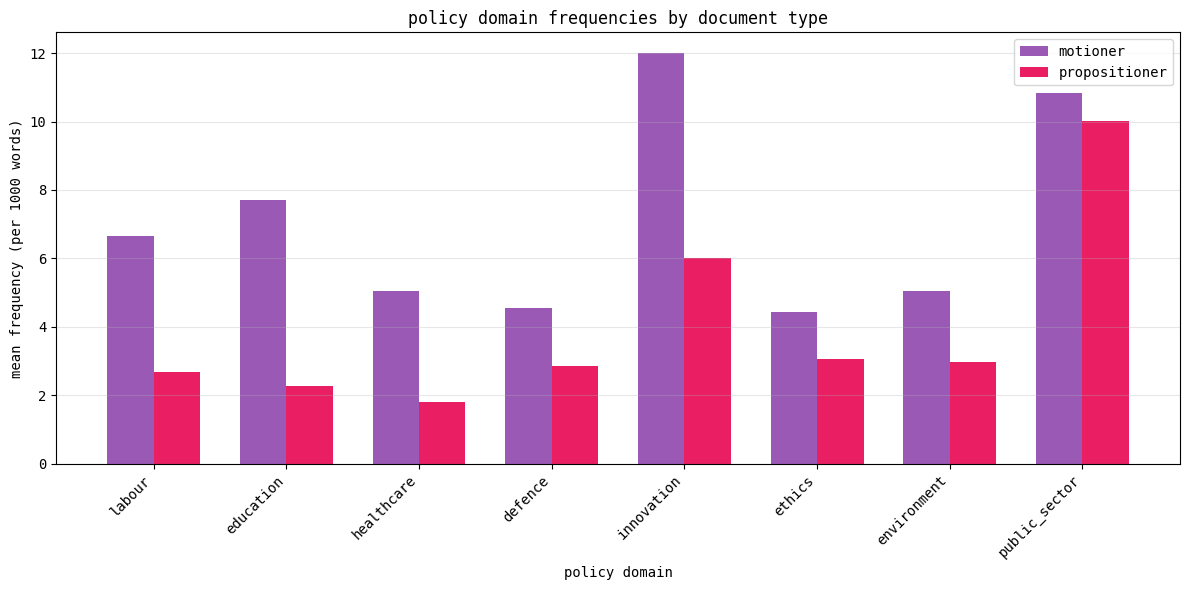

In [8]:
# grouped bar chart comparing domain frequencies
fig, ax = plt.subplots(figsize=(12, 6))

domains = list(policy_domains.keys())
x = np.arange(len(domains))
width = 0.35

mot_means = [df[df['doc_type'] == 'mot'][f'{d}_per_1k'].mean() for d in domains]
prop_means = [df[df['doc_type'] == 'prop'][f'{d}_per_1k'].mean() for d in domains]

ax.bar(x - width/2, mot_means, width, label='motioner', color='#9b59b6')
ax.bar(x + width/2, prop_means, width, label='propositioner', color='#e91e63')

ax.set_xlabel('policy domain')
ax.set_ylabel('mean frequency (per 1000 words)')
ax.set_title('policy domain frequencies by document type')
ax.set_xticks(x)
ax.set_xticklabels(domains, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

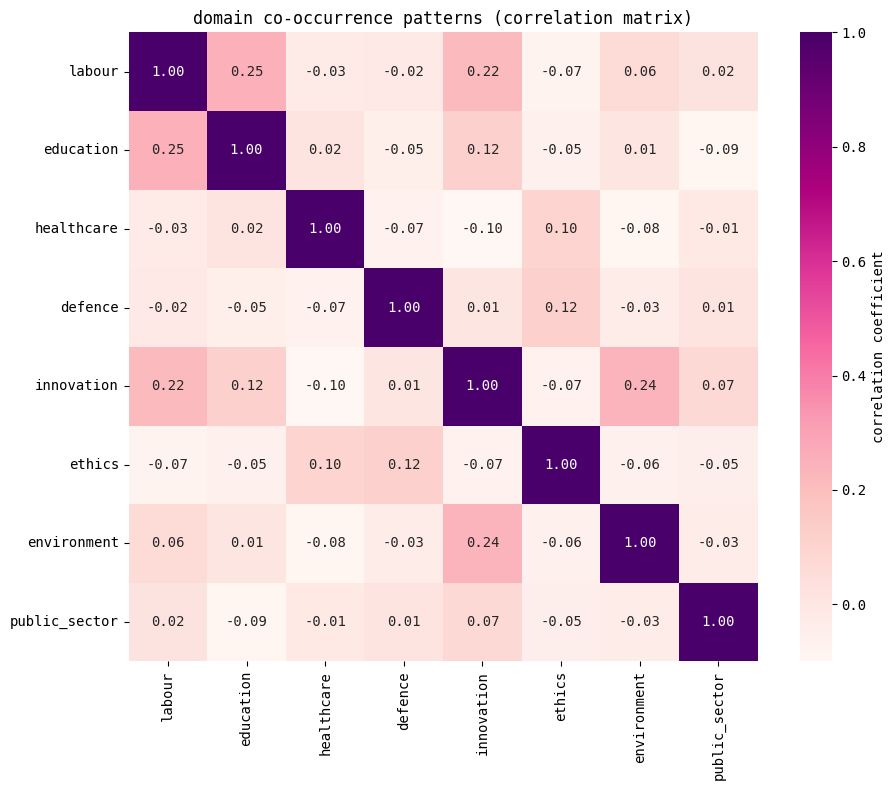

In [9]:
# heatmap showing domain co-occurrence patterns
# calculate correlation matrix of domain frequencies
domain_freq_cols = [f'{d}_per_1k' for d in policy_domains.keys()]
correlation_matrix = df[domain_freq_cols].corr()

# rename for clarity
correlation_matrix.columns = list(policy_domains.keys())
correlation_matrix.index = list(policy_domains.keys())

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdPu',
    square=True,
    cbar_kws={'label': 'correlation coefficient'},
    ax=ax
)

ax.set_title('domain co-occurrence patterns (correlation matrix)')

plt.tight_layout()
plt.show()

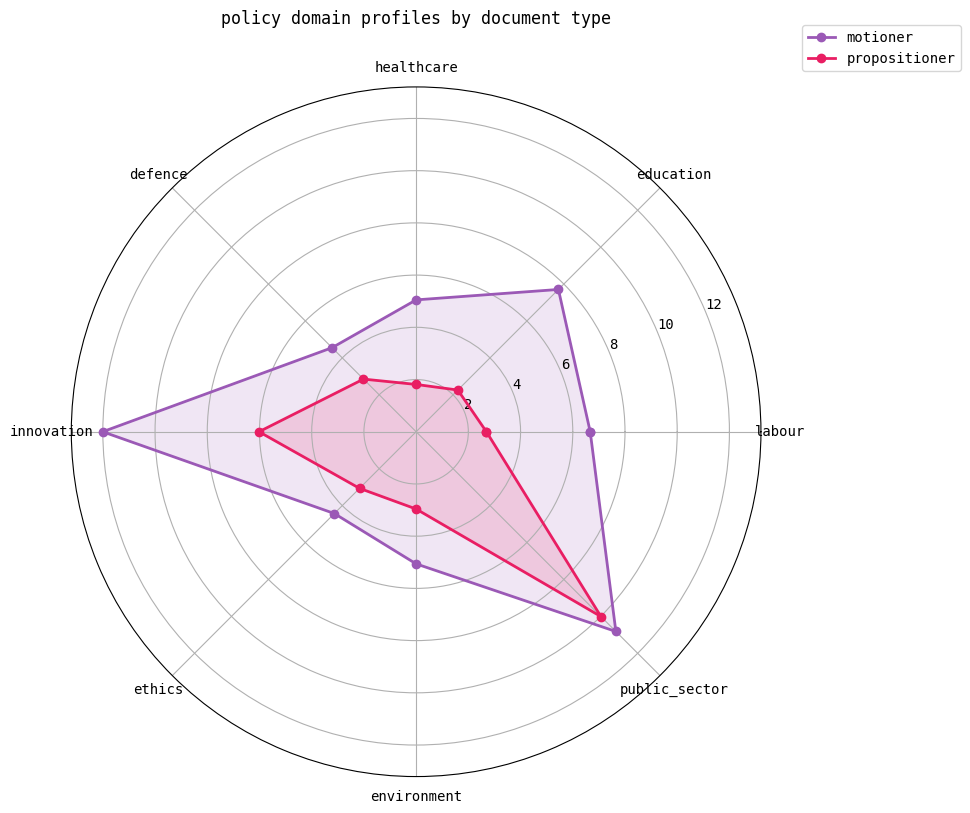

In [10]:
# radar chart showing domain profiles
from math import pi

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# prepare data
domains = list(policy_domains.keys())
angles = [n / len(domains) * 2 * pi for n in range(len(domains))]
angles += angles[:1]  # complete the circle

mot_values = [df[df['doc_type'] == 'mot'][f'{d}_per_1k'].mean() for d in domains]
prop_values = [df[df['doc_type'] == 'prop'][f'{d}_per_1k'].mean() for d in domains]

mot_values += mot_values[:1]  # complete the circle
prop_values += prop_values[:1]

# plot
ax.plot(angles, mot_values, 'o-', linewidth=2, label='motioner', color='#9b59b6')
ax.fill(angles, mot_values, alpha=0.15, color='#9b59b6')

ax.plot(angles, prop_values, 'o-', linewidth=2, label='propositioner', color='#e91e63')
ax.fill(angles, prop_values, alpha=0.15, color='#e91e63')

# configure axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(domains)
ax.set_ylim(0, max(max(mot_values), max(prop_values)) * 1.1)
ax.set_title('policy domain profiles by document type', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

## Statistical comparison

Identify which domains show the strongest over-representation or under-representation in each document type.

In [11]:
# calculate over/under-representation ratios
comparison = pd.DataFrame({
    'domain': list(policy_domains.keys()),
    'mot_mean': [df[df['doc_type'] == 'mot'][f'{d}_per_1k'].mean() for d in policy_domains.keys()],
    'prop_mean': [df[df['doc_type'] == 'prop'][f'{d}_per_1k'].mean() for d in policy_domains.keys()],
    'mot_median': [df[df['doc_type'] == 'mot'][f'{d}_per_1k'].median() for d in policy_domains.keys()],
    'prop_median': [df[df['doc_type'] == 'prop'][f'{d}_per_1k'].median() for d in policy_domains.keys()]
})

# calculate differences and ratios
comparison['diff'] = comparison['mot_mean'] - comparison['prop_mean']
comparison['ratio'] = comparison['mot_mean'] / comparison['prop_mean']

# add interpretation
comparison['favours'] = comparison['diff'].apply(
    lambda x: 'motioner' if x > 0 else 'propositioner'
)

# sort by absolute difference
comparison['abs_diff'] = comparison['diff'].abs()
comparison = comparison.sort_values('abs_diff', ascending=False)

comparison.round(2)

,domain,mot_mean,prop_mean,mot_median,prop_median,diff,ratio,favours,abs_diff
4,innovation,12.01,6.02,8.58,3.97,5.99,1.99,motioner,5.99
1,education,7.71,2.26,3.58,0.50,5.45,3.41,motioner,5.45
0,labour,6.67,2.69,4.18,1.05,3.98,2.48,motioner,3.98
2,healthcare,5.05,1.81,0.90,0.48,3.24,2.79,motioner,3.24
6,environment,5.06,2.96,1.56,0.30,2.10,1.71,motioner,2.10
3,defence,4.55,2.85,1.25,0.90,1.70,1.60,motioner,1.70
5,ethics,4.43,3.07,2.58,1.54,1.36,1.44,motioner,1.36
7,public_sector,10.82,10.01,8.02,8.08,0.81,1.08,motioner,0.81


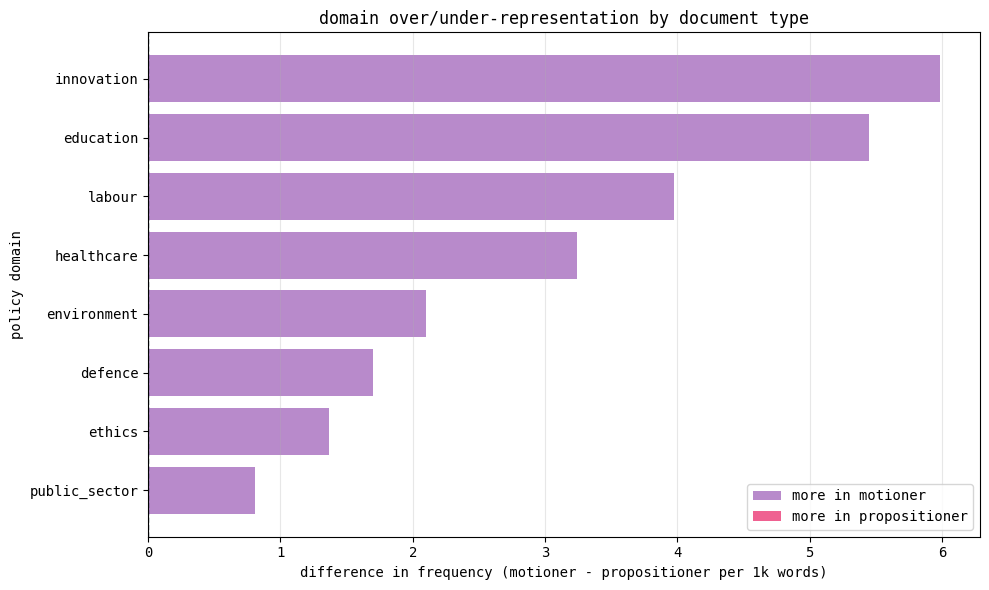

In [12]:
# visualisation: domain differences (mot - prop)
fig, ax = plt.subplots(figsize=(10, 6))

comparison_sorted = comparison.sort_values('diff')
colors = ['#9b59b6' if x > 0 else '#e91e63' for x in comparison_sorted['diff']]

ax.barh(comparison_sorted['domain'], comparison_sorted['diff'], color=colors, alpha=0.7)
ax.axvline(0, color='#34495e', linewidth=1, linestyle='--')

ax.set_xlabel('difference in frequency (motioner - propositioner per 1k words)')
ax.set_ylabel('policy domain')
ax.set_title('domain over/under-representation by document type')
ax.grid(axis='x', alpha=0.3)

# add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#9b59b6', alpha=0.7, label='more in motioner'),
    Patch(facecolor='#e91e63', alpha=0.7, label='more in propositioner')
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

## Summary statistics

Generate interpretable summary of domain distribution patterns.

In [13]:
print("=" * 60)
print("POLICY DOMAIN ANALYSIS SUMMARY")
print("=" * 60)
print(f"\ntotal documents analysed: {len(df)}")
print(f"  - motioner: {len(df[df['doc_type'] == 'mot'])}")
print(f"  - propositioner: {len(df[df['doc_type'] == 'prop'])}")

print("\ntop 3 domains in motioner:")
mot_top = comparison.sort_values('mot_mean', ascending=False).head(3)
for idx, row in mot_top.iterrows():
    print(f"  {row['domain']}: {row['mot_mean']:.2f} per 1k words")

print("\ntop 3 domains in propositioner:")
prop_top = comparison.sort_values('prop_mean', ascending=False).head(3)
for idx, row in prop_top.iterrows():
    print(f"  {row['domain']}: {row['prop_mean']:.2f} per 1k words")

print("\ndomains most over-represented in motioner (vs propositioner):")
mot_over = comparison.sort_values('diff', ascending=False).head(3)
for idx, row in mot_over.iterrows():
    print(f"  {row['domain']}: +{row['diff']:.2f} per 1k words")

print("\ndomains most over-represented in propositioner (vs motioner):")
prop_over = comparison.sort_values('diff').head(3)
for idx, row in prop_over.iterrows():
    print(f"  {row['domain']}: {row['diff']:.2f} per 1k words")

print("=" * 60)

POLICY DOMAIN ANALYSIS SUMMARY

total documents analysed: 1152
  - motioner: 452
  - propositioner: 700

top 3 domains in motioner:
  innovation: 12.01 per 1k words
  public_sector: 10.82 per 1k words
  education: 7.71 per 1k words

top 3 domains in propositioner:
  public_sector: 10.01 per 1k words
  innovation: 6.02 per 1k words
  ethics: 3.07 per 1k words

domains most over-represented in motioner (vs propositioner):
  innovation: +5.99 per 1k words
  education: +5.45 per 1k words
  labour: +3.98 per 1k words

domains most over-represented in propositioner (vs motioner):
  public_sector: 0.81 per 1k words
  ethics: 1.36 per 1k words
  defence: 1.70 per 1k words


## Export results

Save document-level domain frequencies and aggregate comparisons for further analysis.

In [14]:
# create output directory
output_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results')
output_dir.mkdir(exist_ok=True)

# export document-level domain frequencies
export_cols = ['doc_id', 'doc_type', 'title', 'date', 'year', 'word_count'] + \
              [f'{d}_per_1k' for d in policy_domains.keys()]
df[export_cols].to_csv(output_dir / 'rq2_document_themes.csv', index=False)

# export domain comparison summary
comparison[['domain', 'mot_mean', 'prop_mean', 'mot_median', 'prop_median', 
            'diff', 'ratio', 'favours']].to_csv(
    output_dir / 'rq2_domain_comparison.csv', index=False
)

print(f"results exported to {output_dir}")
print(f"  - rq2_document_themes.csv ({len(df)} documents)")
print(f"  - rq2_domain_comparison.csv ({len(comparison)} domains)")

results exported to /Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results
  - rq2_document_themes.csv (1152 documents)
  - rq2_domain_comparison.csv (8 domains)
